In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
import pystan

In [3]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [20]:
model_reg_log = """
data {
  int N;
  int D;
  vector y[N];
  matrix[N, D] x;
}
parameters {
  vector[D] beta;
}
model {
    vector[N] x_beta;
    
    for (i in 1:D)
        beta[i] ~ normal(0, 2);

    x_beta = x * beta;
    
    y ~ categorical_logit(x_beta);
    

}
"""


sm = pystan.StanModel(model_code=model_reg_log)

ValueError: Failed to parse Stan model 'anon_model_428cfd22a410971faaa267707a52a439'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

  error in 'unknown file name' at line 5, column 9
  -------------------------------------------------
     3:   int N;
     4:   int D;
     5:   vector y[N];
                ^
     6:   matrix[N, D] x;
  -------------------------------------------------

PARSER EXPECTED: <size declaration: integer (data-only) in square brackets>


In [59]:
D = 5
N = 100
sig_beta = 10

In [60]:
beta_star = sig_beta * np.random.randn(D) #real value of Beta

X = np.random.randn(N, D)

probas = sigmoid(np.dot(X, beta_star))

Y = np.array([np.random.binomial(1, proba) for proba in probas])

In [61]:
reg_log_parameters = {'N': N,
               'D': D,
                'x' : X,
                'y' : Y}

fit = sm.sampling(data=reg_log_parameters, iter=1000, chains=1, n_jobs=1)

RuntimeError: Initialization failed.

# Modèle logistique

In [16]:
import pystan
#import stan_toolkit as stlk
import numpy as np
#import ess

In [17]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

model_code = '''
data {
       int<lower=0> d; //dimension of the problem
       int<lower=0> n_obs; //nb of observations
       int<lower=0> Y[n_obs]; //binary response variables
       row_vector[d] X[n_obs]; // covariate variables
}

parameters {
    real beta; // intercept
    vector[d] theta; // regressors
}

model {
theta ~ normal(0,1);
beta ~ normal(0,1);
for (i in 1:n_obs){
Y[i] ~ bernoulli(inv_logit(beta + X[i]*theta));
}
}'''
sm = pystan.StanModel(model_code=model_code)
#stlk.save_model(sm,'log_reg_model.pic')
#sm = stlk.load_model('log_reg_model.pic')

In [18]:
model_code = '''
data {
       int<lower=0> d; //dimension of the problem
       int<lower=0> n_obs; //nb of observations
       int<lower=0> Y[n_obs]; //binary response variables
       row_vector[d] X[n_obs]; // covariate variables
       real sig_beta; //sd of beta
}

parameters {
    vector[d] beta; // regressors
}

model {
beta ~ normal(0, sig_beta*sig_beta);
for (i in 1:n_obs){
Y[i] ~ bernoulli(inv_logit(X[i]*beta));
}
}'''
sm = pystan.StanModel(model_code=model_code)
#stlk.save_model(sm,'log_reg_model.pic')
#sm = stlk.load_model('log_reg_model.pic')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5e52471405febb4fd795c9c93db74a82 NOW.
/Data/miniconda3/envs/modal/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpqx9bhqvw/stanfit4anon_model_5e52471405febb4fd795c9c93db74a82_2545636979438907737.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [63]:
d = 5
n_obs = 2000
sig_beta = 10

N_samples_for_estimation = 1000
step = 100

In [64]:
beta_star = sig_beta * np.random.randn(d) #real value of Beta

X = np.random.randn(n_obs, d)

probas = sigmoid(np.dot(X, beta_star))
Y = np.array([np.random.binomial(1, proba) for proba in probas])


In [65]:
print(beta_star)

[ 3.6434338  -5.06779265  3.19570998 -2.31701501 -1.31484999]


In [66]:


# learn parameters
n_chains = 1
warmup = 1000
n_iter = warmup + N_samples_for_estimation
data_stan_log_reg = { 'd' : d, 'n_obs' : n_obs, 'Y' : Y, 'X' : X, 'sig_beta' : sig_beta}
control = dict(metric="unit_e")
fit1 = sm.sampling(data=data_stan_log_reg, control = control, algorithm
= "NUTS", warmup = warmup ,iter=n_iter, chains= n_chains)
step_sizes =  fit1.get_sampler_params()[0]['stepsize__'][-1]

In [67]:
print(fit1.stansummary())

Inference for Stan model: anon_model_5e52471405febb4fd795c9c93db74a82.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   3.62    0.02   0.24   3.19   3.46   3.61   3.78   4.11    244   1.01
beta[2]  -4.97    0.02   0.31  -5.62   -5.2  -4.95  -4.75  -4.42    249   1.01
beta[3]   3.01    0.01   0.21   2.62   2.87    3.0   3.15   3.45    248   1.01
beta[4]  -2.16  9.5e-3   0.16  -2.49  -2.27  -2.16  -2.03  -1.87    293   1.01
beta[5]  -1.44  7.0e-3   0.13  -1.71  -1.53  -1.44  -1.35  -1.19    360    1.0
lp__    -334.1     0.1   1.63 -338.2 -335.0 -333.7 -332.9 -331.8    274    1.0

Samples were drawn using NUTS at Fri Jan 11 12:20:04 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


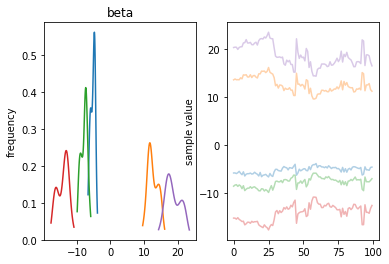

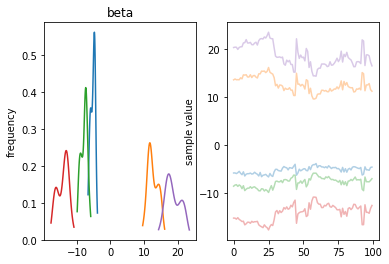

In [24]:
fit1.plot()

In [49]:
def check_concentration(speed, N_samples_for_estimation, n_obs, d, sig_ep, sig_beta, step=30, n_trials_per_step=10):
    df = pd.DataFrame(columns=["n", "proba"])
    
    df_distance = pd.DataFrame(columns=["n", "distance"])
    
    beta_star = sig_beta*np.random.randn(d) #real value of Beta
    for trial in range(n_trials_per_step):
        print("done " + str(100*trial/n_trials_per_step) + " % of work")
        for i in range(1, n_obs, step): 

            
            X = np.random.randn(i, d)

            probas = sigmoid(np.dot(X, beta_star))
            Y = np.array([np.random.binomial(1, proba) for proba in probas])
            
            # learn parameters
            n_chains = 1
            warmup = 800
            n_iter = warmup + N_samples_for_estimation
            data_stan_log_reg = { 'd' : d, 'n_obs' : i, 'Y' : Y, 'X' : X, 'sig_beta' : sig_beta}
            control = dict(metric="unit_e")
            fit1 = sm.sampling(data=data_stan_log_reg, control = control, algorithm
            = "NUTS", warmup = warmup ,iter=n_iter, chains= n_chains)
            step_sizes =  fit1.get_sampler_params()[0]['stepsize__'][-1]
            
            posterior_beta = fit1.extract()["beta"]
            
            aux = [np.linalg.norm(posterior_beta[k] - beta_star) < 1 / speed(k) for k in range(N_samples_for_estimation)]
            proba = sum(aux) / N_samples_for_estimation
            
            aux2 = np.mean([np.linalg.norm(posterior_beta[k] - beta_star) for k in range(N_samples_for_estimation)])
            
            df2 = pd.DataFrame([[i, proba]],columns=['n', 'proba'])
            df2_distance = pd.DataFrame([[i, aux2]],columns=['n', 'distance'])
            df = pd.concat([df,df2])
            df_distance = pd.concat([df_distance,df2_distance])
    
    #sns.barplot(x='n', y="proba", data = df)
    #sns.barplot(x='n', y="distance", data = df_distance)
    return df, df_distance

def check_concentration(speed, N_samples_for_estimation, n_obs, d, sig_ep, sig_beta, step=30, n_trials_per_step=10):
    result = []
    
    df = pd.DataFrame(columns=["n", "proba"])
    
    df_distance = pd.DataFrame(columns=["n", "distance"])
    
    beta_star = sig_beta*np.random.randn(d) #real value of Beta
    for trial in range(n_trials_per_step):
        print("done " + str(100*trial/n_trials_per_step) + " % of work")
        for i in range(1, n_obs, step): 

            
            X = np.random.randn(n_obs, d)

            probas = sigmoid(np.dot(X, beta_star))
            Y = np.array([np.random.binomial(1, proba) for proba in probas])
            
            # learn parameters
            n_chains = 1
            warmup = 800
            n_iter = warmup + N_samples_for_estimation
            data_stan_log_reg = { 'd' : d, 'n_obs' : n_obs, 'Y' : Y, 'X' : X, 'sig_beta' : sig_beta}
            control = dict(metric="unit_e")
            fit1 = sm.sampling(data=data_stan_log_reg, control = control, algorithm
            = "NUTS", warmup = warmup ,iter=n_iter, chains= n_chains)
            step_sizes =  fit1.get_sampler_params()[0]['stepsize__'][-1]
            
            posterior_beta = fit1.extract()["beta"]
            
            aux = [np.linalg.norm(posterior_beta[i] - beta_star) < 1 / speed(i) for i in range(N_samples_for_estimation)]
            proba = sum(aux) / N_samples_for_estimation
            
            aux2 = np.mean([np.linalg.norm(posterior_beta[i] - beta_star) for i in range(N_samples_for_estimation)])
            
            df2 = pd.DataFrame([[i, proba]],columns=['n', 'proba'])
            df2_distance = pd.DataFrame([[i, aux2]],columns=['n', 'distance'])
            df = pd.concat([df,df2])
            df_distance = pd.concat([df_distance,df2_distance])
    
    #sns.barplot(x='n', y="proba", data = df)
    #sns.barplot(x='n', y="distance", data = df_distance)
    return df, df_distance

In [53]:
step = 300
n_obs = 2000
N_samples_for_estimation = 30
n_trials_per_step = 5
df, df_distance = check_concentration(lambda x: np.log(x), N_samples_for_estimation, n_obs=n_obs, d=5, sig_ep=1, sig_beta=10, step=step, n_trials_per_step=n_trials_per_step);

done 0.0 % of work


/Data/miniconda3/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Data/miniconda3/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


done 20.0 % of work


done 40.0 % of work


done 60.0 % of work


done 80.0 % of work


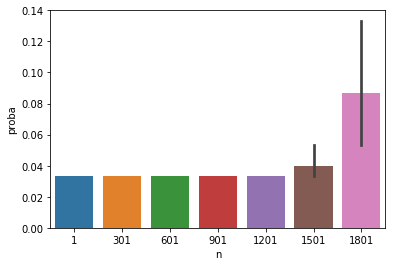

In [54]:
sns.barplot(x='n', y="proba", data = df)

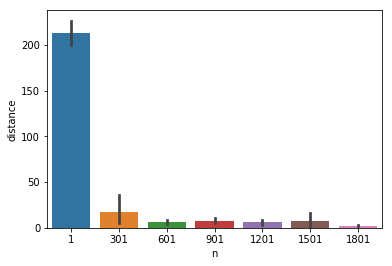

In [55]:
sns.barplot(x='n', y="distance", data = df_distance)

In [57]:
step = 300
n_obs = 2000
N_samples_for_estimation = 30
n_trials_per_step = 5
df, df_distance = check_concentration(lambda x: np.sqrt(x), N_samples_for_estimation, n_obs=n_obs, d=5, sig_ep=1, sig_beta=10, step=step, n_trials_per_step=n_trials_per_step);

done 0.0 % of work


/Data/miniconda3/envs/modal/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


done 20.0 % of work


done 40.0 % of work


done 60.0 % of work


done 80.0 % of work


In [ ]:
def compare_to_speed(res_of_fit, speed):
    df_proba = pd.DataFrame(columns=["n", "proba"])
    df_proba["n"] = df_distance["n"]
    
    distance = df_distance["distance"]
    aux = [distance[i] < 1 / speed(i) for i in range(len(distance))]
    for trial in range(n_trials):
        for i in range(1, n_obs, step):
            distances = res_of
            aux = [distance[i] < 1 / speed(i) for i in range(len(distance))]
            proba = sum(aux) / len(distances)
            new_df = pd.DataFrame([[i, proba]],columns=['n', 'proba'])
            df_proba = pd.concat([df_proba, new_df])
            
    sns.barplot(x="n", y="proba", data=df_proba)
            
    

In [8]:
#real sampling
n_iter = 1000
n_chains = 1
warmup = 0
control = dict(metric="unit_e", stepsize=step_sizes,adapt_engaged=0)

In [9]:
def theta_0_fun(): return {'theta' : np.random.randn(d), 'beta' :
np.random.randn()}
fit1 = sm.sampling(data = data_stan_log_reg, algorithm = "NUTS", control
= control, warmup = warmup ,iter=n_iter,  chains= n_chains, init =
theta_0_fun)

In [10]:
step_sizes =  fit1.get_sampler_params()[0]['stepsize__'][-1]
print(step_sizes)

0.5556058059789319


In [8]:
## return an array of three dimensions: iterations, chains, parameters
a = fit1.extract(permuted=False)
a=a[:,:,:d]
n_iter_eff = n_iter - warmup

# save chain with two dimensions : iterations, chains x parameters
a = a.reshape((n_iter_eff,n_chains*d))
#MODIFIED np.savetxt('samples_nuts/log_reg.txt',a)
#a = np.loadtxt('samples_nuts/gaussian.txt')

# get number of evaluation of the gradient
eval_gradient = np.zeros([n_chains,n_iter])
iter_i = 0
sampler_params = fit1.get_sampler_params()
for i in sampler_params:
     eval_gradient[iter_i,:] = i['n_leapfrog__']
     iter_i = iter_i+1
#MODIFIED np.savetxt('samples_nuts/eval_gradient_log_reg.txt',eval_gradient)

#Compute ess
a = a.reshape((n_iter_eff,n_chains,d))
#ess.generate_neff(a)

In [9]:
a

array([[[-0.59667568, -0.45445424, -0.54495224,  1.08711973]],

       [[ 1.51374522,  1.58562497,  0.5624768 , -0.36489122]],

       [[ 0.64938825,  0.44276045,  0.13774222,  0.11696965]],

       [[ 0.40123331,  2.28049835,  0.04203849, -0.96491301]],

       [[ 0.60105795,  2.31538613,  0.08847465, -0.63752821]],

       [[ 0.15277873,  0.49721942, -0.53919032,  0.10697472]],

       [[ 0.15277873,  0.49721942, -0.53919032,  0.10697472]],

       [[ 0.66867792,  0.48883167, -0.55864853, -0.34765757]],

       [[ 0.00790011,  0.54962286,  0.54378569,  0.61816129]],

       [[ 0.69901944, -0.58167447, -1.05809154,  0.75674925]]])